In [1]:
import os
# Uncomment if you don't want to use GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

from MultipoleNet import load_model, build_graph_batched, D_Q
from rdkit import Chem
from rdkit.Chem import AllChem
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[]

In [2]:
dtype = np.float32 

## Model Loading (Main)
Load the model weights: 

In [3]:
model = load_model()

## Multipole Prediction for a Single Molecule

In [4]:
# Create molecule with RDKit (example: Aspirin)
rdkit_mol = Chem.AddHs(Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')) 
elements = [a.GetSymbol() for a in rdkit_mol.GetAtoms()]
# Generate a conformation
AllChem.EmbedMolecule(rdkit_mol)
coordinates = rdkit_mol.GetConformer(0).GetPositions().astype(dtype)

In [5]:
# Predict Multipole for some Conformation:
monopoles, dipoles, quadrupoles = model.predict(coordinates, elements)

In [7]:
# Rotating the dipoles or the molecule shouldn't make a difference...
rotation = R.random()
r_matrix = rotation.as_matrix().astype(dtype)
np.allclose(tf.matmul(model.predict(coordinates, elements)[1], r_matrix.T), 
            model.predict(tf.matmul(coordinates, r_matrix.T), elements)[1], 
            atol=np.finfo(dtype).resolution) # atol depends on the used dtype - 

True

In [8]:
# and quadrupoles
np.allclose(tf.matmul(r_matrix, tf.matmul(model.predict(coordinates, elements)[2], r_matrix.T)), 
            model.predict(tf.matmul(coordinates, r_matrix.T), elements)[2],
            atol=np.finfo(dtype).resolution)

True

## Bached Multipole Prediction
If you have the proper hardware available and multiple conformations of the same molecule, this option will be much faster:

In [11]:
n_conformations = 2500
rdkit_mol.RemoveAllConformers()
AllChem.EmbedMultipleConfs(rdkit_mol, numConfs=n_conformations)
coords_batch = tf.convert_to_tensor(([conformation.GetPositions().astype(dtype) for conformation in rdkit_mol.GetConformers()]))
coords_model_input = tf.reshape(coords_batch, [-1, 3]) # The model expects coords in shape Nx3

Lets check the timings:

In [18]:
%%timeit
graphs = build_graph_batched(coords_batch, elements, cutoff=4.0, num_kernels=32)

5.95 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
model(graphs, coords_model_input);

411 ms ± 6.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Using a Titan V we obtained following timings:

411ms for 52'500 atoms / 2500 aspirin conformations (using the main model)

Compared to the actual prediction, the graph construction is negligible. As noted in the publication, this step depends on the size of the molecules and can be sped up in applications where multipoles are predicted for the same molecule repeatedly.

## Reference Calculations
We can use the Psi4 QM library to obtain reference multipoles/ESPs.
Let's first generate a surface around the molecule:

In [6]:
N_points, CUTOFF = 400, 4.0
monomer_coords = coordinates.copy()
surface_points = np.random.normal(size=[N_points, 3])
surface_points = (surface_points / np.linalg.norm(surface_points, axis=-1, keepdims=True)) * CUTOFF
surface_points = np.reshape(surface_points[None] + monomer_coords[:, None], [-1, 3])
surface_points = surface_points[np.where(np.all(cdist(surface_points, monomer_coords) >= (CUTOFF - 1e-1), axis=-1))[0]]
surface_points.shape

(1244, 3)

In [7]:
with open('grid.dat', 'w') as file:
    for xyz in surface_points:
        for c in xyz:
            file.write(str(c) + ' ')
        file.write('\n')

In [8]:
# Lets do a reference calculation.
import psi4
psi4.set_options({'basis': 'def2-TZVP'})
B_to_A = 0.529177249

In [9]:
psi4_mol = psi4.core.Molecule.from_arrays(monomer_coords, elem=elements)
psi4.core.set_output_file('output.dat', False)
e, wfn = psi4.energy('PBE0', molecule=psi4_mol, return_wfn=True)
psi4.oeprop(wfn, 'GRID_ESP', 'MBIS_CHARGES', title='MBIS Multipoles')
reference_esp = [float(x) for x in open('grid_esp.dat')]

In [17]:
wfn_variables = wfn.variables()
monopoles_ref = wfn_variables['MBIS CHARGES']
dipoles_ref = wfn_variables['MBIS DIPOLES'] * B_to_A # Convert to e/A
quadrupoles_ref = D_Q(wfn_variables['MBIS QUADRUPOLES'] * B_to_A ** 2).numpy() # Convert to e/A**2 and detrace

0.0017258705


(-0.8246967439537354, 0.9944293067944121)

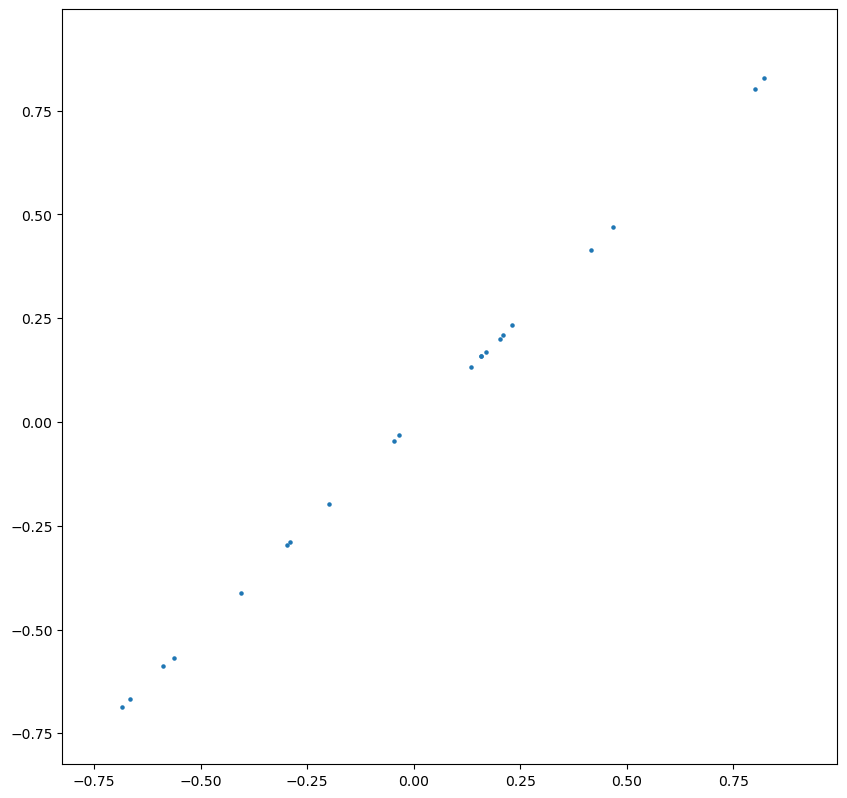

In [11]:
plt.figure(0, figsize=(10, 10), dpi=100)
plt.scatter(monopoles, monopoles_ref, s=5)
print(np.mean(np.abs(monopoles - monopoles_ref)))
min_x, max_x = np.amin(monopoles_ref) * 1.2, np.amax(monopoles_ref) * 1.2
ax = plt.gca()
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_x, max_x)

0.0009122615


(-0.07264698456108318, 0.06805027538363581)

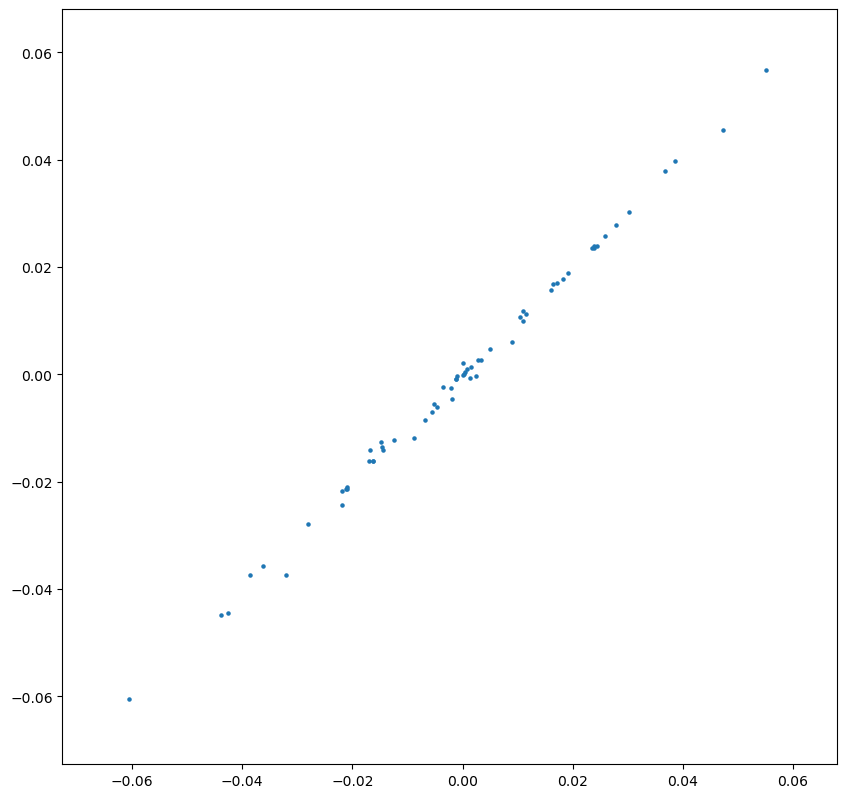

In [12]:
plt.figure(0, figsize=(10, 10), dpi=100)
plt.scatter(dipoles, dipoles_ref, s=5)
print(np.mean(np.abs(dipoles - dipoles_ref)))
min_x, max_x = np.amin(dipoles_ref) * 1.2, np.amax(dipoles_ref) * 1.2
ax = plt.gca()
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_x, max_x)

0.000476136


(-0.03363489088641615, 0.05108393590339469)

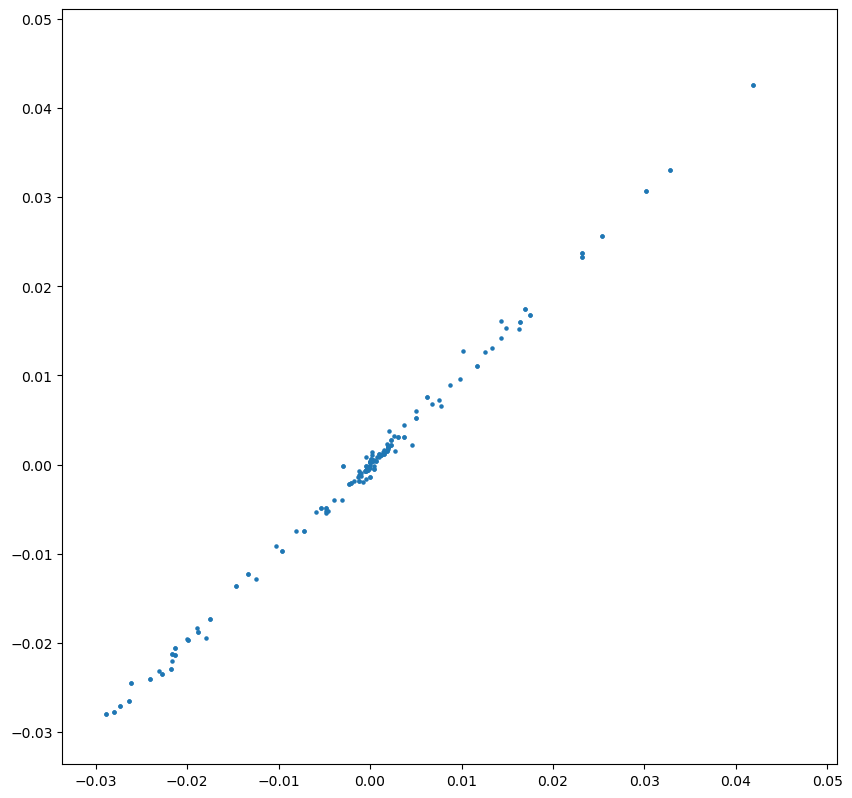

In [18]:
plt.figure(0, figsize=(10, 10), dpi=100)
plt.scatter(quadrupoles, quadrupoles_ref, s=5)
print(np.mean(np.abs(quadrupoles - quadrupoles_ref)))
min_x, max_x = np.amin(quadrupoles_ref) * 1.2, np.amax(quadrupoles_ref) * 1.2
ax = plt.gca()
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_x, max_x)

In [14]:
# Checkout the ESP on the surface
dmat = cdist(monomer_coords, surface_points)
monopoles_esp = tf.reduce_sum(monopoles / dmat, axis=-2) * 1389.35 # eps0
ref_esp = np.array(reference_esp) * 2625.5 # Hartree to kJ/mol
np.mean(np.abs(monopoles_esp - ref_esp))

2.820202

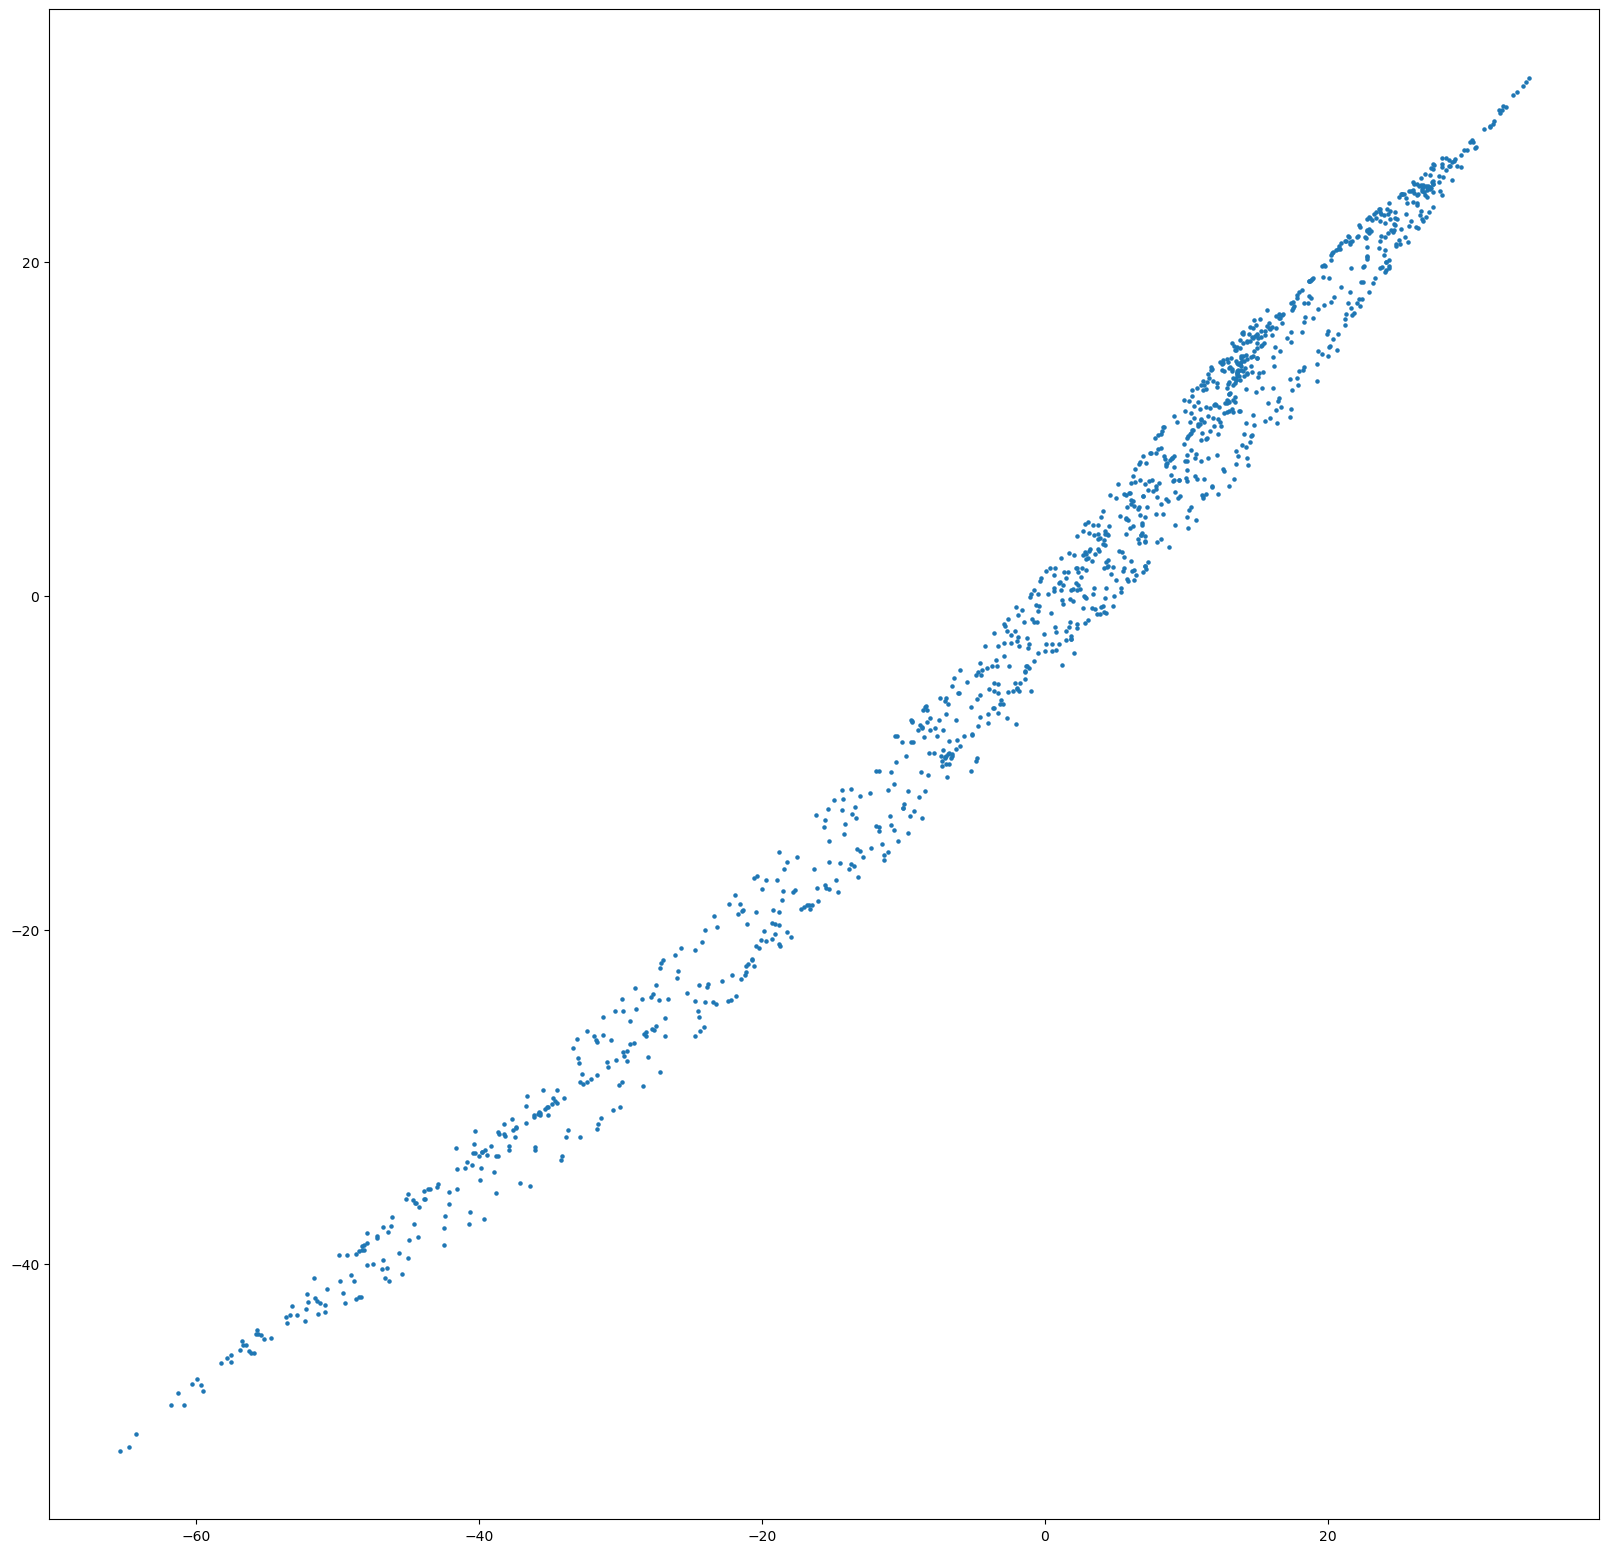

In [15]:
plt.figure(0, figsize=(20, 20), dpi=100)
plt.scatter(monopoles_esp, ref_esp, s=5)